# Tutorial 01: Running Sumo/Flow Simulations

This tutorial walks a reader through setting up a basic FLOW simulation environment, initializing an attacking model, and subsequently running a simulation to understand the behavior of the simulation. Information from the FLOW tutorials may be repeated.

---

Every simulation in Flow/Anti-Flow is executed by the `Experiment` object. The `Experiment` object expects 10 total arguments for the simulation configuration, which can be largely categorized into 2 types : *network* arguments, and *environment* arguments. **Network Arguments** describe the features of the transportation network used in simulation which includes properties of vehicles, traffic lights, inflows, etc. in the network. **Environment Arguments** deal with initializing and advancing simulations, and well as storing the simulation data for later use. Moreover, custom environments may be used to modify the dynamical features of a network. Below is a visual breakdown of the needed parameters. Exact descriptions for each parameter will be given further below.

**Expeceted Arguments for** `Experiment`
* Network Arguments
    * name 
    * vehicles
    * net_params
    * initial_config
    * traffic_lights
* Environment Arguments
    * network
    * simulator
    * sim_params
    * Environment Name
    * env_params
    
---

## Part 1. The Ring Road Simulation without an Attacker

In Part 1, we will begin with setting up one of the simplest traffic simulation environments, the ring-road. On a ring-road, a finite number of vehicles follow one another continuously. Part 1 will simulate a ring-road network with 25 normal vehicles. Part 2 will simulate a ring-road network with 24 normal vehicles and 1 attack vehicle which will cause irregularities in the traffic flow.

### 1.1. Setting up the Network Arguments

First, we will initialize all 5 network arguments. The following code shows how to initialize these quantities.

#### 1.1.1. Name
The `name` argument is a simple string variable depicting the name of the network. This does not affect the type of network being created. Instead, the `network` variable defines the type of the network which we will initialize later. 

In [1]:
name = 'ring_no_attack'

#### 1.1.2. Vehicles
The `vehicles` argument holds state information on all vehicles in the network simulation. We manage this information using the `VehicleParams` class. Once a `VehicleParams` object is created, vehicles may be introduced using the `add` method. This method specifies the types and quantities of vehicles at the start of a simulation rollout. For a description of the various arguements associated with the `add` method, we refer the reader to the following documentation ([VehicleParams.add](https://flow.readthedocs.io/en/latest/flow.core.html?highlight=vehicleparam#flow.core.params.VehicleParams)).

In [2]:
from flow.core.params import VehicleParams
from flow.controllers.car_following_models import IDMController # A driving model that simulates a human driver.
from flow.controllers.routing_controllers import ContinuousRouter # A Router that keeps vehicles on the ring-road.

vehicles = VehicleParams() # The vehicles object will store different classes of drivers:


num_human_drivers = 20  # Specify how many human driven vehicles will drive:
# Define a driver model human drivers:
vehicles.add("human",
             acceleration_controller=(IDMController, {'noise':0.1}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=num_human_drivers)

#### 1.1.3. Net Params
The `NetParams` argument defines the shape and properties within a network. The details of `NetParams` may vary drasitcally depending on the specific network configuration such as a ring-road or a straight road. For the ring-road, we will use 4 specifications : length of the road, number of lanes, speed limit for all vehicles, and the resolution of the curves on the ring.

In [3]:
from flow.core.params import NetParams

ring_length = 300 # Diameter of the ring-road
lanes = 1 # Number of lanes in the ring-road
speed_limit = 30 # Speed limit for all vehicles
resolution = 40 # Resolution of the curves

net_params = NetParams(additional_params={'length': ring_length,
                                          'lanes': lanes,
                                          'speed_limit': speed_limit,
                                          'resolution': resolution})

#### 1.1.4. Initial Config
The `InitialConfig` argument specifies parameters that affect the positions of the vehicles at the start of a simulation. In order to introduce a small initial disturbance to the system of vehicles in the network, we set the `perturbation` term in `InitialConfig` to 1m.

In [4]:
from flow.core.params import InitialConfig

initial_config = InitialConfig(spacing="uniform", perturbation=1) # Vehicles start out evenly spaced.

#### 1.1.5. Traffic Light Params
The `TrafficLightParams` argument defines the positions and types of traffic lights in the network. For the simulation, we do not place any traffic lights, therefore an empty `TrafficLightParams` object will be used.

In [5]:
from flow.core.params import TrafficLightParams

traffic_lights = TrafficLightParams() # This is empty, so no traffic lights are used.

### 1.2. Setting up the Environment Arguments

Next, we will initialize the environment arguments.

#### 1.2.1. Network
The `Network` argument specifies the type of network our simulation is based on. This simulation relies on a ring-road, therefore we will import a `RingNetwork` class.

In [6]:
from flow.networks.ring import RingNetwork

#### 1.2.2. Simulator
The `Simulator` argument specifies the traffic simulator to be used.

In [7]:
sim = 'traci'

#### 1.2.3. Sim Params
`SimParams` specifies simulation-specific variables. These variables may include the length of a simulation step (in seconds), whether to render the GUI when running the experiment, and other variables. Another useful parameter is `emission_path`, which is used to specify the path where the emissions output will be generated. They contain a lot of information about the simulation, for instance the position and speed of each car at each time step. If you do not specify any emission path, the emission file will not be generated.

In [8]:
from flow.core.params import SumoParams

#Simulation parameters:
time_step = 0.1 # In seconds, how far each step of the simulation goes.
want_render = True # If we want SUMO to render the environment and display the simulation.
emission_path = 'data' # Result file location.

# Sets the simulation time-step and where data will be recorded.
sim_params = SumoParams(sim_step=time_step, render=want_render, emission_path=emission_path) 

#### 1.2.4. Environment Name
Several envionrments in Flow/Anti-Flow exist to train autonomous agents of different forms (e.g. autonomous vehicles, traffic lights) to perform a variety of different tasks. These environments are often network- or task-specific; however, some can be deployed on an ambiguous set of networks as well. One such environment, `AccelEnv`, may be used to train a variable number of vehicles in a fully observable network with a *static* number of vehicles.

In [9]:
from flow.envs.ring.accel import AccelEnv

#### 1.2.5. Env Params
`EnvParams` specify environment and experiment-specific parameters that either affect the training process or the dynamics of various components within the network. Much like `NetParams`, the attributes associated with this parameter are mostly environment-specific, and can be found in the environment's `ADDITIONAL_ENV_PARAMS` dictionary. Importing the `ADDITIONAL_ENV_PARAMS` variable, we see that it consists of only one entry, "target_velocity", which is used when computing the reward function associated with the environment. We use this default value when generating the `EnvParams` object.

In [10]:
from flow.core.params import EnvParams
from flow.envs.ring.accel import ADDITIONAL_ENV_PARAMS

env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS)

### 1.3. Running the Simulation

We have now properly configured all 10 arguments needed to run a Flow/Anti-Flow simulation experiment. We will package these 10 arguments into a dictionary which will be used to instantiate an `Experiment` object. 

In [11]:
import os
from flow.core.experiment import Experiment

# Compile all simulation parameters as a dictionary.
flow_params = dict(
    exp_tag=name,
    veh=vehicles,
    net=net_params,
    initial=initial_config,
    tls=traffic_lights,
    network=RingNetwork,
    simulator=sim,
    sim=sim_params,
    env_name=AccelEnv,
    env=env_params
)

sim_horizon = 3000 # How many simulation steps will be taken -> Runs for 300 seconds

# Set the number of time steps and initialize the exp object with the simulation parameters.
flow_params['env'].horizon = sim_horizon
exp = Experiment(flow_params)

print('Simulation ready.')

Simulation ready.


Let's now run a simulation which doesn't have any malicious vehicles, and only human drivers:

In [12]:
# Run the simulation and save the data:
sim_res_list = exp.run(1, convert_to_csv=True)

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 2204.0387005583493
data/ring_no_attack_20220712-1725271657664727.79246-0_emission.csv data
Average, std velocities: 7.359306945701747, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 2204.0387005583493, 0.0
Total time: 26.5372211933136
steps/second: 152.19987612246027


### 1.4. Visualize Simulation Results:

First, we need to find the path to the experiment that was just run, which is stored in the exp object. Plotting tools for visualizing the traffic can then be used, which are found in flow\visualize. We plot the spacetime diagram which shows a slight travelling waves develop and then move backwards against the traffic flow.

Data loaded.


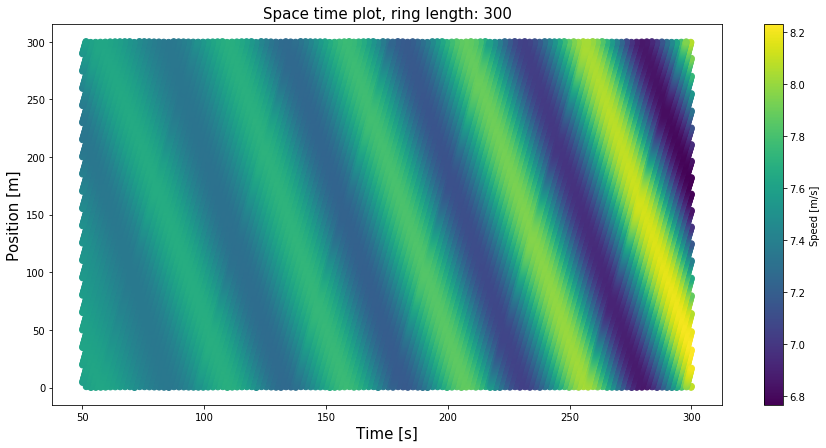

In [13]:
import flow.visualize.visualize_ring as visualize_ring
%matplotlib inline

emission_location = os.path.join(os.getcwd(),sim_res_list[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_location)

## Part 2. The Ring Road Simulation with an Adversary/Attacker

In Part 2, we introduce a single attacker / adversary (term used interchangeably) in the ring-road simulation. Since an attack vehicle should behave differently from the normal vehicles on the road, it requires a new configuration that defines those desired movements. This can be achieved through passing the desired movements through the `acceleration_controller` parameter when introducing the vehicle with `vehicle.add()`.

### 2.1. Setting up Configuration for Simulation

In this Tutorial, we want the attack vehicle to act as a compromised ACC model which executes a randomized deceleration event (RDA). A single ACC vehicle is defined with a given attack mangitude and duration. The attacker waits 50 seconds, and travels 900 m before it executes its attack, and the attack is only executed once. We will configure this specific behavior / attack with a separate acceleration controller.

Instead of configuring the arguments needed for the `Experiment` object in separate cells, we will set up all 10 arguments below. All other arguments remain unchanged from Part 1 except for the `vehicles` argument.

In [14]:
from Adversaries.controllers.car_following_adversarial import ACC_Switched_Controller_Attacked_Single

# Reinstantiate the VehicleParams object
vehicles = VehicleParams()

# Add 19 normal human drivers
num_human_drivers = 19

vehicles.add("human",
             acceleration_controller=(IDMController, {'noise':0.1}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=num_human_drivers)


# Configure acceleration controller for ACC vecicle executing a randomized deceleration event(RDA).
attack_duration = 10 # How long the vehicle will slow down for.
attack_magnitude = -5 # In m/s^2 how strong the braking event is.
adversary_ACC_controller = (ACC_Switched_Controller_Attacked_Single,{
    'warmup_steps': 500,
    'distance_threshold_max': 800,
    'Total_Attack_Duration': attack_duration,
    'attack_decel_rate': attack_magnitude,
    'display_attack_info': False,
    'V_m': 15.0})

vehicles.add("AV_Adv",
             acceleration_controller=adversary_ACC_controller,
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=1)

# Re-compile all simulation parameters as a dictionary:
flow_params = dict(
    exp_tag='ring_with_attack',
    veh=vehicles,
    net=net_params,
    initial=initial_config,
    tls=traffic_lights,
    network=RingNetwork,
    simulator=sim,
    sim=sim_params,
    env_name=AccelEnv,
    env=env_params
)

# number of time steps
flow_params['env'].horizon = sim_horizon
exp = Experiment(flow_params)

print('Simulation ready.')             

Simulation ready.


### 2.2. Run Simulation & Visualize Data

Now we execute the simulation and visualize the results.

Attack ACC spawned : AV_Adv_0 warmup steps: 500 attack distance: 828.1085838796346


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1742.3263175757702
data/ring_with_attack_20220712-1725591657664759.15452-0_emission.csv data
Average, std velocities: 6.245997234046102, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1742.3263175757702, 0.0
Total time: 26.588054895401
steps/second: 153.65470765774015
Simulation complete.
Data loaded.


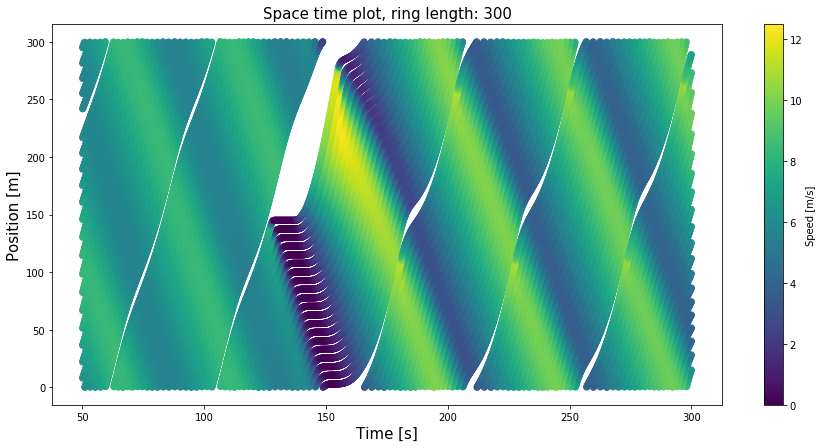

In [15]:
%matplotlib inline

sim_res_list = exp.run(1, convert_to_csv=True)
print('Simulation complete.')

emission_location = os.path.join(os.getcwd(),sim_res_list[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_location)

The attack, which happens around position 150, and time 120, first brings traffic to a stand-still and subsequently creates a travelling wave of larger magnitude than the un-attacked traffic.

## Bibliography
[1] Sugiyama, Yuki, et al. "Traffic jams without bottlenecks—experimental evidence for the physical mechanism of the formation of a jam." New journal of physics 10.3 (2008): 033001.

[2] Treiber, Martin, Ansgar Hennecke, and Dirk Helbing. "Congested traffic states in empirical observations and microscopic simulations." Physical review E 62.2 (2000): 1805.